<a href="https://colab.research.google.com/github/Isafon/ECE528/blob/main/ECE528_ASN5_Q3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving iot-util.csv to iot-util.csv


In [2]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM,SimpleRNN, Activation,Dropout
import numpy as np
from keras.optimizers import Adam
from keras.layers import Bidirectional
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [185]:
epochs = 5
batch_size = 50

In [186]:
# Each training data point will be length 100-1,
# since the last value in each sequence is the label
sequence_length = 100

In [414]:
#isa model
def generate_model():
    model = Sequential()

    # Input
    model.add(keras.layers.Input(shape=(sequence_length - 1, 1)))

    # First LSTM layer — minor increase in dropout for stability
    model.add(LSTM(128, activation='tanh', return_sequences=True))
    model.add(Dropout(0.31))  # just enough to calm normal points slightly

    # Second LSTM layer — matching damping
    model.add(LSTM(64, activation='tanh', return_sequences=True))
    model.add(Dropout(0.32))

    # Third LSTM layer — same for anomaly sensitivity
    model.add(LSTM(32, activation='relu', return_sequences=False))

    # Output
    model.add(Dense(1))

    # Learning rate slightly slower to smooth out minor noise
    optimizer = Adam(learning_rate=0.00036)
    model.compile(loss='mse', optimizer=optimizer, metrics=['root_mean_squared_error'])

    return model

In [415]:
def normalize(result):
    result_mean = result.mean()
    result_std = result.std()
    result -= result_mean
    result /= result_std
    return result, result_mean

In [416]:
def prepare_data(data, train_start, train_end, test_start, test_end):
    print("Length of Data", len(data))

    # training data
    print("Creating training data...")

    result = []
    for index in range(train_start, train_end - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)
    result, result_mean = normalize(result)

    print("Training data shape  : ", result.shape)

    train = result[train_start:train_end, :]
    np.random.shuffle(train)
    X_train = train[:, :-1]
    y_train = train[:, -1]

    # test data
    print("Creating test data...")

    result = []
    for index in range(test_start, test_end - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)
    result, result_mean = normalize(result)

    print("Test data shape  : {}".format(result.shape))

    X_test = result[:, :-1]
    y_test = result[:, -1]

    print("Shape X_train", np.shape(X_train))
    print("Shape X_test", np.shape(X_test))

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return X_train, y_train, X_test, y_test

In [417]:
def run(model=None, data=None):
    global_start_time = time.time()

    print('Loading data... ')
    data_b = pd.read_csv('iot-util.csv',
                         parse_dates=[0], infer_datetime_format=True)
    data = data_b['cpu'].to_numpy()

    # train on first 500 samples and test on last 160 samples (test set has anomaly)
    X_train, y_train, X_test, y_test = prepare_data(data, 0, 600, 400, 660)

    if model is None:
        model = generate_model()

    try:
        print("Training...")
        model.fit(
                X_train, y_train,
                batch_size=batch_size, epochs=epochs, validation_split=0.05)
        print("Predicting...")
        predicted = model.predict(X_test, verbose=1)
        print("Reshaping predicted")
        predicted = np.reshape(predicted, (predicted.size,))
    except KeyboardInterrupt:
        print("prediction exception")
        print('Training duration:{}'.format(time.time() - global_start_time))
        return model, y_test, 0

    try:
        rmse_series = np.sqrt((y_test - predicted) ** 2)
        plt.figure(figsize=(20,8))
        plt.plot(y_test[:len(y_test)], 'b', label='Observed')
        plt.plot(predicted[:len(y_test)], 'g', label='Predicted')
        plt.plot(rmse_series, 'r', label='RMSE (per time step)')
        plt.legend()
        plt.show()
    except Exception as e:
        print("plotting exception")
        print(str(e))
    print('Training duration:{}'.format(time.time() - global_start_time))

    return model, y_test, predicted

Loading data... 
Length of Data 660
Creating training data...
Training data shape  :  (500, 100)
Creating test data...
Test data shape  : (160, 100)
Shape X_train (500, 99)
Shape X_test (160, 99)
Training...
Epoch 1/5


/tmp/ipython-input-1696365755.py:5: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data_b = pd.read_csv('iot-util.csv',


10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 391ms/step - loss: 0.8750 - root_mean_squared_error: 0.9347 - val_loss: 0.4041 - val_root_mean_squared_error: 0.6357
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 328ms/step - loss: 0.5039 - root_mean_squared_error: 0.7093 - val_loss: 0.2087 - val_root_mean_squared_error: 0.4568
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 276ms/step - loss: 0.3847 - root_mean_squared_error: 0.6198 - val_loss: 0.1501 - val_root_mean_squared_error: 0.3874
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 278ms/step - loss: 0.3154 - root_mean_squared_error: 0.5604 - val_loss: 0.0784 - val_root_mean_squared_error: 0.2800
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 427ms/step - loss: 0.2479 - root_mean_squared_error: 0.4947 - val_loss: 0.0535 - val_root_mean_squared_error: 0.2314
Predicting...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
Reshaping predicted


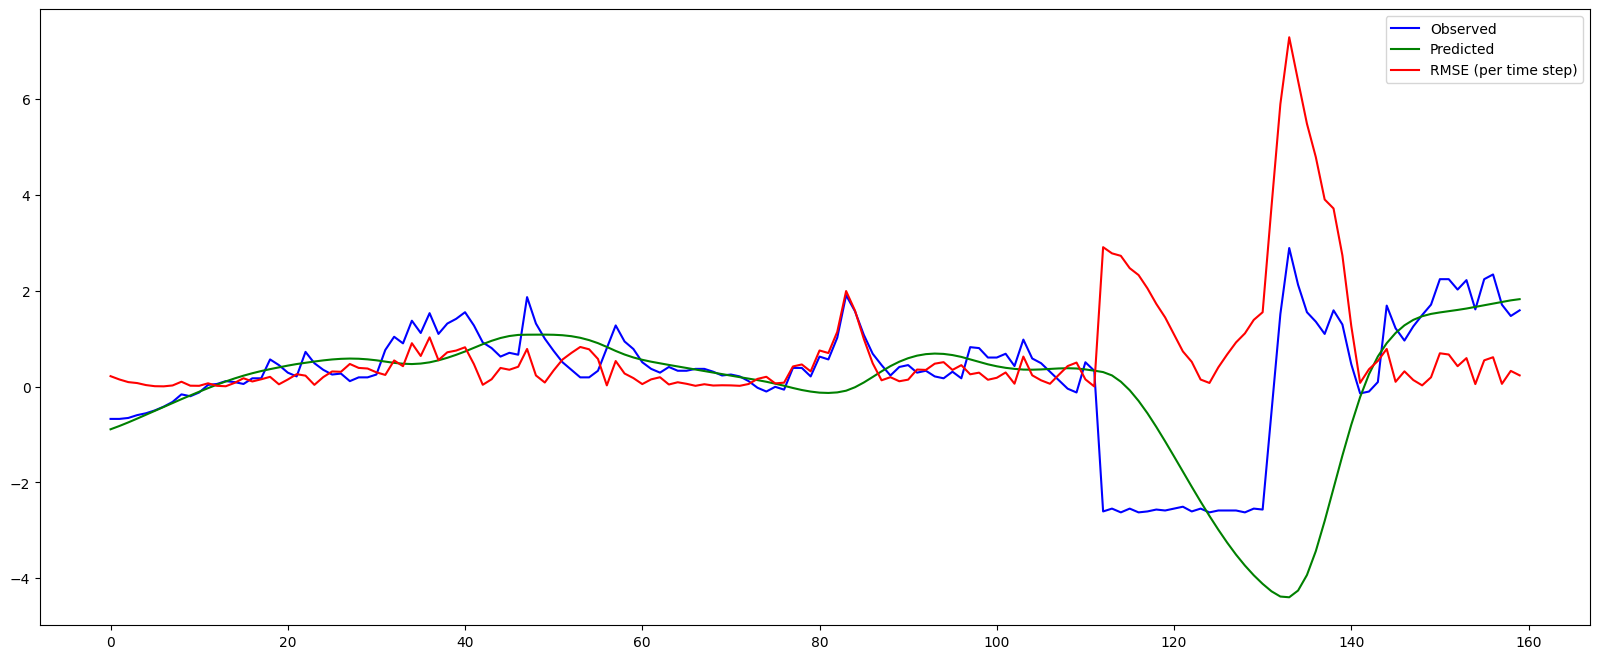

Training duration:25.479305267333984


In [418]:
model, y_test, predicted = run()

In [419]:
start_time = 0
rmse_series = np.sqrt((y_test - predicted) ** 2)

mean_rmse = np.mean(rmse_series)
std_rmse  = np.std(rmse_series)
# Anomaly threshold = Mean RMSE + 2 * Std RMSE is chosen based on empirical analyses
threshold = mean_rmse + 1.8 * std_rmse

print(f"Mean RMSE: {mean_rmse:.3f}")
print(f"Standard Deviation of RMSE: {std_rmse:.3f}")
print(f"Anomaly Threshold: {threshold:.3f}\n")

# Detect anomalies (indices where RMSE > threshold)
anomaly_indices = np.where(rmse_series > threshold)[0]

if len(anomaly_indices) > 0:
    print("Detected anomalies (index, RMSE):")
    for idx in anomaly_indices:
        print(f"Anomaly at time {start_time + idx} | RMSE value: {rmse_series[idx]:.3f}")

# Calculate RMSE(normal), RMSE(anomaly), and SNR

if len(anomaly_indices) > 0:
    rmse_anomaly = rmse_series[anomaly_indices]
    rmse_normal = rmse_series[rmse_series <= threshold]

    mean_rmse_normal = np.mean(rmse_normal)
    mean_rmse_anomaly = np.mean(rmse_anomaly)
    snr = mean_rmse_anomaly / mean_rmse_normal

    print("\n--- Model Evaluation Metrics ---")
    print(f"RMSE (Normal points): {mean_rmse_normal:.3f}")
    print(f"RMSE (Anomaly points): {mean_rmse_anomaly:.3f}")
    print(f"Signal-to-Noise Ratio (SNR): {snr:.2f}")

Mean RMSE: 0.717
Standard Deviation of RMSE: 1.205
Anomaly Threshold: 2.886

Detected anomalies (index, RMSE):
Anomaly at time 112 | RMSE value: 2.910
Anomaly at time 131 | RMSE value: 3.758
Anomaly at time 132 | RMSE value: 5.898
Anomaly at time 133 | RMSE value: 7.293
Anomaly at time 134 | RMSE value: 6.383
Anomaly at time 135 | RMSE value: 5.487
Anomaly at time 136 | RMSE value: 4.792
Anomaly at time 137 | RMSE value: 3.906
Anomaly at time 138 | RMSE value: 3.718

--- Model Evaluation Metrics ---
RMSE (Normal points): 0.468
RMSE (Anomaly points): 4.905
Signal-to-Noise Ratio (SNR): 10.49
